In [4]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [5]:
import zipfile

zip_path = "/content/dataset.zip"
extract_path = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted files:")
os.listdir("/content/data")


Extracted files:


['data']

In [6]:
data_path = "/content/data/data"

pkl_files = [f for f in os.listdir(data_path) if f.endswith(".pkl")]

len(pkl_files), pkl_files[:5]


(183,
 ['2018-05-01.pkl',
  '2018-06-04.pkl',
  '2018-08-23.pkl',
  '2018-05-18.pkl',
  '2018-07-23.pkl'])

In [10]:
dfs = []
for file in pkl_files:
    path = f"{data_path}/{file}"
    dfs.append(pd.read_pickle(path))

df = pd.concat(dfs, ignore_index=True)

In [12]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   TRANSACTION_ID     int64         
 1   TX_DATETIME        datetime64[ns]
 2   CUSTOMER_ID        object        
 3   TERMINAL_ID        object        
 4   TX_AMOUNT          float64       
 5   TX_TIME_SECONDS    object        
 6   TX_TIME_DAYS       object        
 7   TX_FRAUD           int64         
 8   TX_FRAUD_SCENARIO  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 120.4+ MB


In [15]:
X = df.drop(
    ["TRANSACTION_ID", "TX_DATETIME", "TX_FRAUD"],
    axis=1
)
y = df["TX_FRAUD"]


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [19]:
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [20]:
y_pred = model.predict(X_test)

In [21]:
accuracy_score(y_test, y_pred)

1.0

In [22]:
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    347895
           1       1.00      1.00      1.00      2936

    accuracy                           1.00    350831
   macro avg       1.00      1.00      1.00    350831
weighted avg       1.00      1.00      1.00    350831



array([[347895,      0],
       [     0,   2936]])

In [24]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])


In [27]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

In [28]:
model = pipeline.named_steps["model"]

feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

feature_importance_df.head(10)


,Feature,Importance
5,TX_FRAUD_SCENARIO,0.938650
2,TX_AMOUNT,0.051768
3,TX_TIME_SECONDS,0.004709
4,TX_TIME_DAYS,0.002622
1,TERMINAL_ID,0.001682
0,CUSTOMER_ID,0.000569


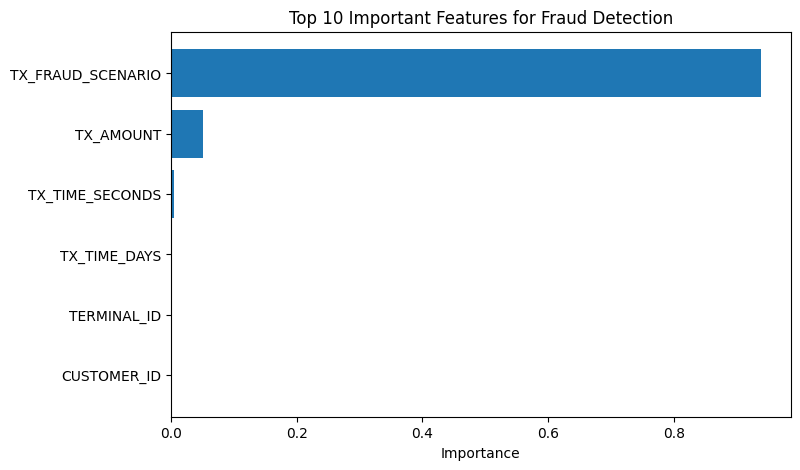

In [29]:
plt.figure(figsize=(8,5))
plt.barh(
    feature_importance_df["Feature"].head(10),
    feature_importance_df["Importance"].head(10)
)
plt.gca().invert_yaxis()
plt.title("Top 10 Important Features for Fraud Detection")
plt.xlabel("Importance")
plt.show()


In [31]:
y_probs = pipeline.predict_proba(X_test)[:, 1]
y_probs[:10]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [32]:
threshold = 0.7
y_custom_pred = (y_probs > threshold).astype(int)


In [33]:
confusion_matrix(y_test, y_custom_pred)


array([[347895,      0],
       [     0,   2936]])

In [34]:
print(classification_report(y_test, y_custom_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    347895
           1       1.00      1.00      1.00      2936

    accuracy                           1.00    350831
   macro avg       1.00      1.00      1.00    350831
weighted avg       1.00      1.00      1.00    350831



In [35]:
sample_input = X.iloc[0].values.reshape(1, -1)
pipeline.predict(sample_input)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0])

In [36]:
pipeline.predict_proba(sample_input)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[1., 0.]])

In [37]:
with open("fraud_model.pkl", "wb") as f:
    pickle.dump(model, f)